In [32]:
import numpy as np
import os
import torch

DATA_PATH = '/rdf/user/pg34/sleep_data/'

In [33]:
train_data = np.load(os.path.join(DATA_PATH, 'Training_new', 'p00_n1_NEW_X.npy'))
train_label = np.load(os.path.join(DATA_PATH, 'Training_new', 'p00_n1_NEW_y.npy'))

In [34]:
print(f"x shape: {train_data.shape}")
print(f"y shape: {train_label.shape}")

x shape: (2650, 6, 3000)
y shape: (2650,)


[1. 2. 3. 4. 5. 6.]
(array([1997,   58,  250,  101,  119,  125]), array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
       5.16666667, 6.        ]))


(array([1997.,   58.,  250.,  101.,  119.,  125.]),
 array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
        5.16666667, 6.        ]),
 <BarContainer object of 6 artists>)

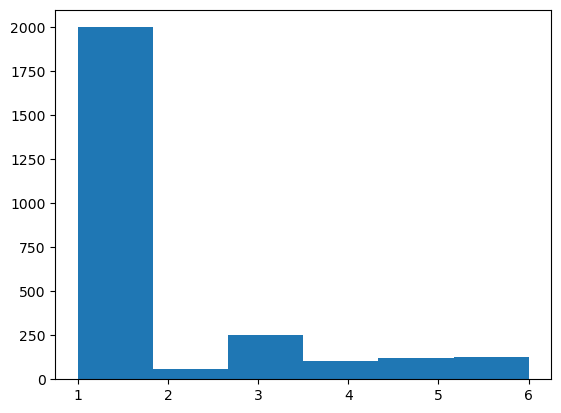

In [35]:
# histogram of labels
print(np.unique(train_label))
print(np.histogram(train_label, bins=6))
# plot of labels
import matplotlib.pyplot as plt
plt.hist(train_label, bins=6)

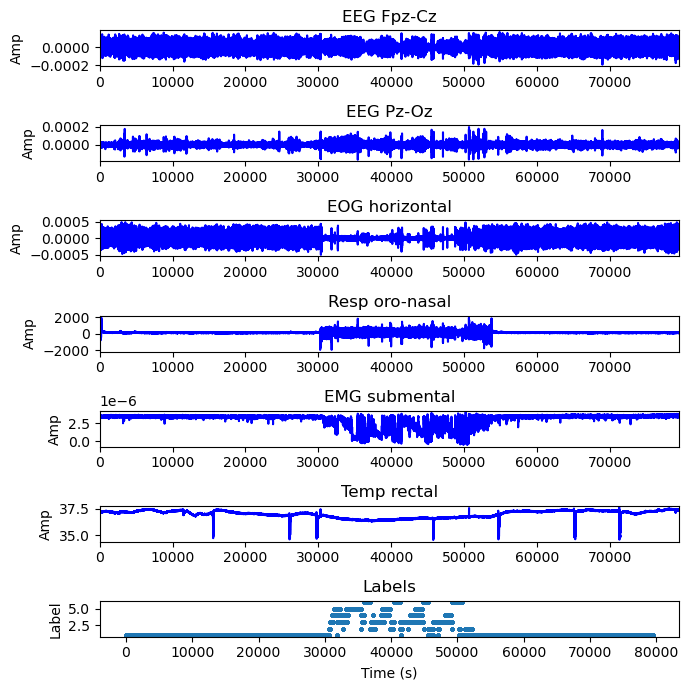

In [36]:
downsampling_factor = 10  
N, channels, data_length = train_data.shape
# Downsample the data
x = train_data[:, :, ::downsampling_factor]
x = np.hstack(x)

# Time vector for plotting (assuming 100Hz sampling rate and downsampling)
continuous_time_vector = np.linspace(0, N * data_length / 100, x.shape[1])
channel_names = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal']


# Re-plotting with the corrected data structure
fig, axs = plt.subplots(channels + 1, 1, figsize=(7, 7))

for i in range(channels):
    axs[i].plot(continuous_time_vector, x[i, :], color='blue')
    axs[i].set_title(channel_names[i])
    axs[i].set_ylabel('Amp')
    axs[i].set_xlim([continuous_time_vector[0], continuous_time_vector[-1]])

# Plotting labels in the last subplot
# Repeating the labels for each data point (assuming each label applies to the entire epoch)
repeated_labels = np.repeat(train_label, data_length)[::downsampling_factor]

axs[-1].plot(continuous_time_vector, repeated_labels, 'o', markersize=2)
axs[-1].set_title('Labels')
axs[-1].set_ylabel('Label')
axs[-1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

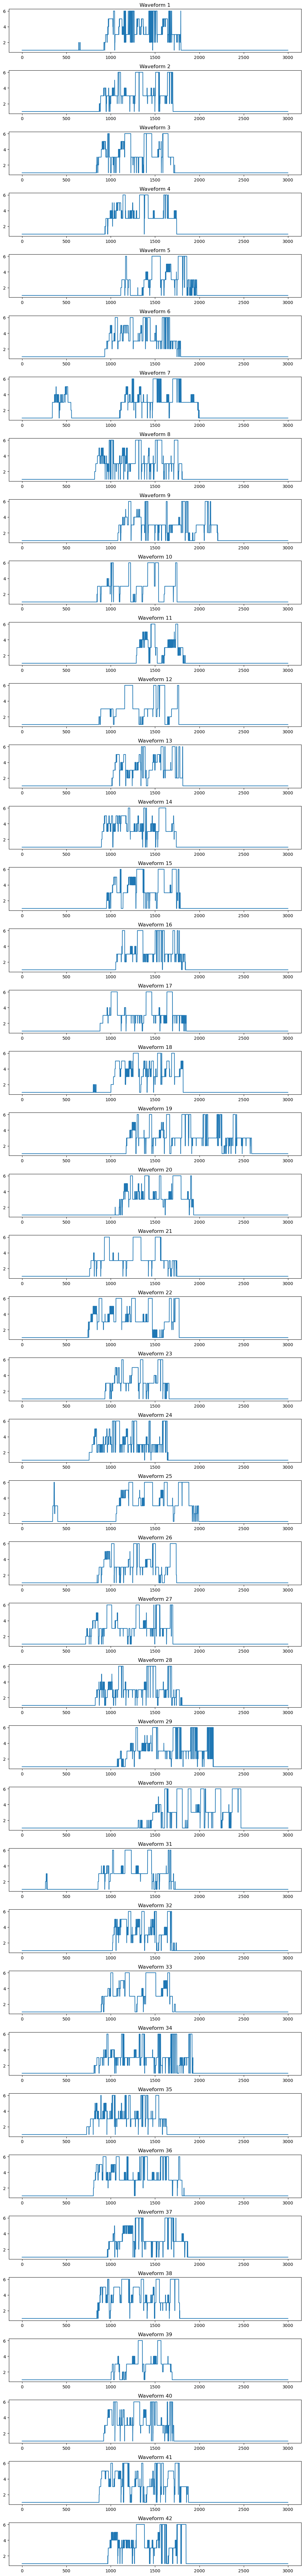

Text(0, 0.5, 'Amplitude')

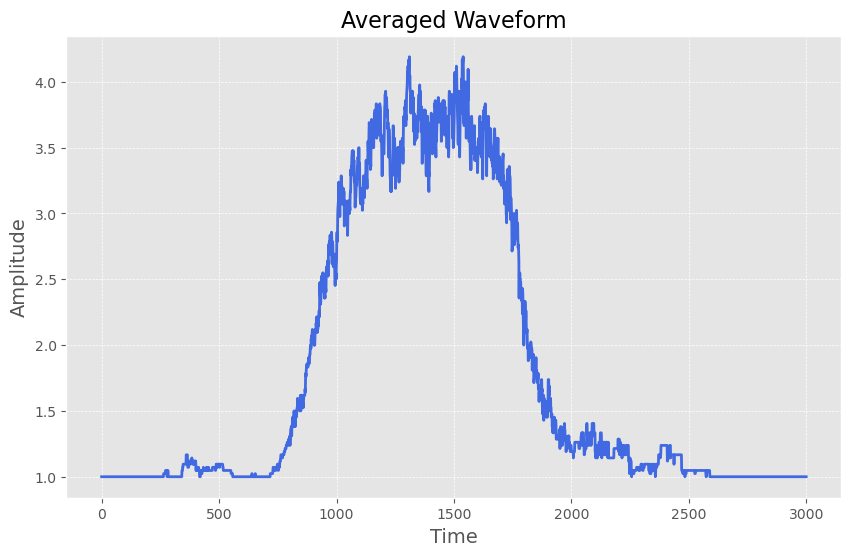

In [42]:
import glob

# Step 1: Loading the label files
file_paths = glob.glob('/rdf/user/pg34/sleep_data/Training_new/*_y.npy')  # Replace with your directory path
data = [np.load(fp) for fp in file_paths]

# Step 2: Padding the data
padded_data = [np.pad(arr, (0, 3000 - len(arr)), 'constant', constant_values=1) if len(arr) < 3000 else arr for arr in data]

# Convert to a 2D numpy array
padded_data_array = np.array(padded_data)

# Step 3: Plotting individual waveforms
plt.figure(figsize=(10, len(padded_data) * 2))
for i, waveform in enumerate(padded_data_array):
    # print(f'max {np.max(waveform)}, min {np.min(waveform)}')
    # print(file_paths[i])
    plt.subplot(len(padded_data), 1, i + 1)
    plt.plot(waveform)
    plt.title(f'Waveform {i+1}')
plt.tight_layout()
plt.show()

# Step 4: Plotting the averaged waveform
# average_waveform = np.mean(padded_data_array, axis=0)
# plt.figure()
# plt.plot(average_waveform)
# plt.title('Averaged Waveform')
# plt.show()
import matplotlib.style as style

# Assuming 'padded_data_array' is your data
average_waveform = np.mean(padded_data_array, axis=0)

# Use a predefined style for aesthetics (optional)
style.use('ggplot')  # You can try different styles like 'seaborn', 'ggplot', etc.

# Create a larger figure for better visibility
plt.figure(figsize=(10, 6))

# Plot the average waveform with a custom line style and color
plt.plot(average_waveform, color='royalblue', linestyle='-', linewidth=2)

# Adding grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding titles and labels
plt.title('Averaged Waveform', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)


In [38]:
print(x.shape)
print(train_label.shape)

(6, 795000)
(2650,)


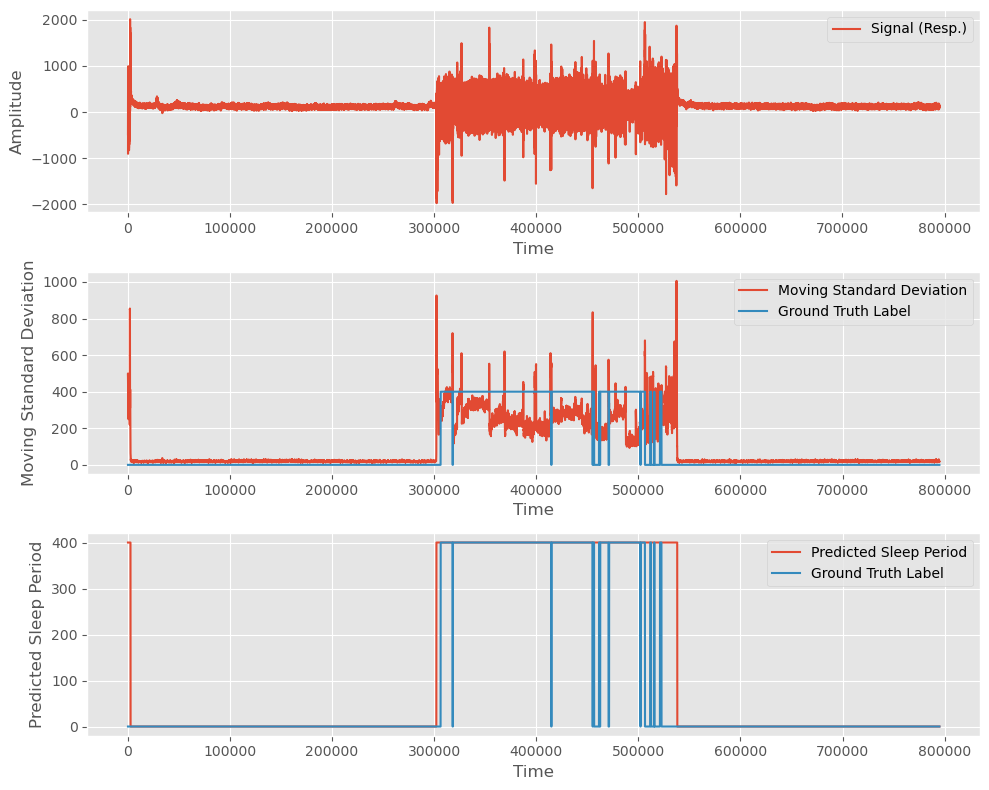

In [45]:

# Parameters
window_size = 300  # Define the window size for calculating the moving statistic
threshold = 80  # Define a threshold for the moving statistic

# Calculate the moving standard deviation
def moving_std(signal, window_size):
    stds = np.array([np.std(signal[i:i+window_size]) for i in range(len(signal) - window_size + 1)])
    return stds

# Compute the moving statistic for the signal
signal = x[3,:]
moving_statistic = moving_std(signal, window_size)

# Apply threshold to determine sleep (1) vs non-sleep (0)
sleep_periods = (moving_statistic > threshold) * 400

# Append label to the bottom
# Plotting the results
fig, axs = plt.subplots(3, 1, figsize=(10, 8))


# Plot the moving standard deviation
# Upsample train_label to match the size of moving_statistic
upsampled_train_label = np.repeat(train_label>1, 300)[149:-150] * 400



# Plot the signal
axs[0].plot(signal, label='Signal (Resp.)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')

# Plot the moving standard deviation
axs[1].plot(np.arange(window_size // 2, len(signal) - (window_size // 2)+1), moving_statistic, label='Moving Standard Deviation')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Moving Standard Deviation')
axs[1].plot(np.arange(window_size // 2, len(signal) - (window_size // 2)+1), upsampled_train_label, label='Ground Truth Label')

# Plot the moving standard deviation
axs[2].plot(np.arange(window_size // 2, len(signal) - (window_size // 2)+1), sleep_periods, label='Predicted Sleep Period')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Predicted Sleep Period')
axs[2].plot(np.arange(window_size // 2, len(signal) - (window_size // 2)+1), upsampled_train_label, label='Ground Truth Label')


# Add legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()
plt.show()
